
- [INTRODUCTION](#introduction)
- [ENVIRONMENT](#environment)
  - [Action](#action)
  - [State](#state)
  - [Reward](#reward)
  - [Goal](#goal)
- [IMPLEMENTATION](#implementation)
  - [Agent](#agent)
  - [Neural network](#neural-network)
  - [Hyperparameters](#hyperparameters)
- [TRAINING](#training)
  - [Platforms](#platforms)
  - [Results, part 1: Fastest solve](#results-part-1-fastest-solve)
  - [Results, part 2: Training is faster on CPU than GPU??](#results-part-2-training-is-faster-on-cpu-than-gpu)
  - [Results, part 3: Benchmark comparisons for 2048 x 2048 x 2048 hidden layers](#results-part-3-benchmark-comparisons-for-2048-x-2048-x-2048-hidden-layers)
  - [Results, part 4: Benchmarks for 4096 x 4096 x 4096](#results-part-4-benchmarks-for-4096-x-4096-x-4096)
- [Failed Attempts](#failed-attempts)
  - [Single network DQN](#single-network-dqn)
  - [Reducing state](#reducing-state)
  - [Lower-dimension hidden layers](#lower-dimension-hidden-layers)
  - [Visual learning using pixels](#visual-learning-using-pixels)
- [Next Steps](#next-steps)
  - [Prioritized replay](#prioritized-replay)
  - [Additional work on the pixel agent](#additional-work-on-the-pixel-agent)


# INTRODUCTION

This project contains the files for the first project in the *Udacity Deep Reinforcement Learning Nanodegree*. It places an agent in an environment where the goal of the agent is to maximize its rewards given a fixed limit of 300 actions.

The environment consists of a walled area with yellow and blue bananas placed at random in the playing field. The goal for the agent is to collect as many **yellow bananas (+1 reward)** as possible while avoiding **blue bananas (-1 reward)**. 

The actions available to the agent are:
* move forwards
* move backwards
* turn left
* turn right

At first the agent's movements are random, but over time it learns which actions to take to maximize its rewards.

The goal of the project is to average 13 points over the previous 100 episodes. If the agent is able to do this, the task is considered "solved" and the training ends.

# ENVIRONMENT


The environment is a C# program running under the Unity engine, and represents a square field with walls on each side. Yellow and blue bananas placed at random locations within this field. At the beginning of each episode, the agent  spawns at a random location on the field.

Interactions with the environment take place using an API defined by the **Unity agents** Python package (the **ML Agents** package can also be used). The scenario is a modified version of the Bananas environment in Unity's ML agents sandbox. The interaction loop consists of:
* Create an instance of the sandbox
* Get the initial state
* Send an action to the instance, and receive the corresponding new state and reward for the action take
* Continue taking action and receiving states and rewards until the sandbox returns **done*** when the episode is complete. An episode is definied to be 300 steps/actions.

### Action

The agent can take one of 4 actions exclusively: move forwards or backwards, or turn left or right. The action is encoded as an integer from 0 to 3.

### State

The state is represented as a 37-dimensional vector, grouped into 7 "rays" emanating out from the "front" of the agent (the direction that the agent is currently facing) in 7 different directions, and 2 floats representing forward and side momentum.

For each "ray", imagine a laser shooting out from the agent at a certain angle, and recording information about the first object that ray "hits", and the distance of the "hit". The angles, as defined in [the banana agent source code](https://github.com/Unity-Technologies/ml-agents/blob/37d139af636e4a2351751fbf0f2fca5a9ed7457f/UnitySDK/Assets/ML-Agents/Examples/BananaCollectors/Scripts/BananaAgent.cs#L44), as: 
```csharp
float[] rayAngles = { 20f, 90f, 160f, 45f, 135f, 70f, 110f };
```

Each "ray" uses 5 numbers to encode the following information:
  * 1 if it is the first item we hit
  * 0 otherwise 

The first 4 numbers represent the following items that the ray "hits" (one-hot encoding, which means that only one of the items is a 1, the rest 0).
  * a yellow banana
  * the wall
  * a blue banana
  * the agent
  
The last number is the distance to the item denoted by a "1" above.

7 "ray" directions X 5 numbers = 35. The last two numbers are the sideways and forward/backwards velocity. The entire state is a vector of length 37.

### Reward

The agent receives a reward of +1 if it "runs over" a yellow banana, and -1 if it "runs over" a blue banana.

### Goal

The goal of the agent is the maximize its reward (in the positive direction). The environment is considered "solved" if the average reward of the last 100 episodes (each episode represents 300 action) is over +13.

# IMPLEMENTATION

### Agent

**File**: `dqn_agent.py`

The agent is implemented using a dual DQN (Deep Q Neural Network) architecture. This means that the agent uses two neural networks to guide its actions: a **local** neural network and a **target** neural network. 

After every agent action, the **local** network is updated with the resulting rewards. In addition, every state --> action --> new_state --> reward tuple is stored in a memory buffer, and that buffer is periodically sampled and used to update the **target** network. After the target network is updated, all the parameters of the **local** network are updated using a **soft update** function. 

The purpose of the **soft udpate** is so that the parameters of the target network are slowly transferred to the local network to smooth out the "bumps", since the local update parameters are more volatile than the target network's parameters. 

Whenever the agent needs take an action, it uses the local network as the **policy**, which, given the current state as input, returns the recommended action. Since the parameters of the local network is initialized with random values, the actions of the agent will initially be random, but as the local network is updated with (state / reward) information, it will eventually learn to maximize the reward.

This cycle continues until the environment is solved.

### Neural network

**File**: `model.py`

The **local** and **target** neural networks have identical architectures. 

The neural network architecture consists of 3 hidden, fully connected layers -- the "classic" neural network. I did not use any type of regularization like *batch normalization*, *dropout*, or *ReLU actvations* -- they were unnecessary given this simple problem. Loss function was MSE (mean-squared error), and the optimizer is Adam.

### Hyperparameters

I limited my parameter tuning to the following 5 hyperparameters:
* the size of the 3 hidden layers
* **batch update frequency**: how many episodes to run before updating the **target** network. Each episode is 300 actions
* **batch size**: how many random samples in each batch update


# TRAINING

### Platforms

Initially, I ran my training on two different platforms:
* a late-2020 **Macbook Pro Max** with an M1 ARM-based processor
* a **m6i.xlarge** spot instance in AWS which cost 8 cents an hour. 

After solving the environment with a small network, I ran benchmarks on other AWS GPU instances, and I've summarized those results below as well.

I ran into issues on each platform.

* **Mac OS**

Since the Bananas Unity environment was compiled for x86, I ran into issues getting it to run on my ARM-based processor. The solution was to enable **Rosetta** (which provides a thin emulation layer for x86 programs for M1 Macs) in a Terminal, and then install the x86 version of Anaconda [according to these instructions](https://towardsdatascience.com/how-to-install-miniconda-x86-64-apple-m1-side-by-side-on-mac-book-m1-a476936bfaf0). After that, I was able to get the Bananas environment running on my laptop, including the visual environment (in my attempt to train an agent using raw pixels).

* **Ubuntu Linux running in AWS cloud**

I was able to get the non-visual environment across different instance and GPU types, but wasn't able to get the visual environment working. Even with X Windows working, the visual environment would not work. I suspect that I need to install the graphical version of Ubuntu and log in with VNC, and at that point I had tried numerous configurations and didn't want to try another one.

### Results, part 1: Fastest solve

All the results in the following table were run on an **m6i.xlarge** spot instance in AWS, which at the time of use was 8 cents an hour.

The table shows the hyperparameters for the training runs in the order I ran the training. Even after the environment was "solved", I still wanted to find the fastest training configuration.

In prior training runs not shown below, I experimented with smaller batch size and more frequent updates. However, expanding the batch size and reducing the frequency sped up the training without affecting performance, and I settled on `BATCH_SIZE = 128` and `UPDATE_EVERY = 6` early on did not alter them for subsequent runs.

As you can see from the sequence of hyperparameter tuning, I kept reducing the size of the hidden layers to see if solve times would also decrease. At some point the number of parameters is too low for the agent to "remember" past states, and that point occurred at **32 / 32 / 32**, which is not shown here.

**64 / 64 / 64** is the winner for the fastest training session as well as the lowest viable size of the fully-connected neural network.

| Time | episodes |  NN structure    | batch size | update every |
|:----:|:--------:|:----------------:|:----------:|:------------:|
|  638 |    559   |  512 / 512 / 256 |     128    |       6      |
|  348 |    434   |  256 / 256 / 256 |     128    |       6      |
|  526 |    567   |  256 / 256 / 64  |     32     |       2      |
|  343 |    563   |  256 / 256 / 64  |     128    |      12      |
|  393 |    599   |  256 / 256 / 64  |     256    |      12      |
|  964 |    513   | 2048 / 512 / 128 |     128    |       6      |
|  369 |    584   |  256 / 256 / 64  |     128    |      12      |
|  370 |    484   |  256 / 256 / 64  |     128    |       6      |
|  320 |    453   |  128 / 128 / 64  |     128    |       6      |
|  310 |    455   |  128 / 128 / 64  |     128    |       6      |
|  343 |    484   |   64 / 64 / 64   |     128    |       6      |
|  294 |    452   |   64 / 64 / 64   |     128    |       6      |

**How to read this table**

* **Time**: Time in seconds to solve the environment
* **episodes**: number of episodes required to solve the environment
* **structure**: The number of parameters in each hidden layer. In all cases, 3 hidden layers were used
* **batch size**: number of samples for each target network update
* **update every**: how many episodes between each target network update

All other parameters were unchanged, and are defined near the top of the `dqn_agent.py` file.

The boldfaced training run, which took **310 seconds** and **455 episodes** to solve, is included in the project in the file `Fastest.ipynb`. The corresponding checkpoint file is `fastest_checkpoint.pth`. (The graph for the actual fastest run at **294 seconds** did not save correctly, so I am using 310 seconds as the fastest training run).

This is a screen shot of the training report for the fastest run:

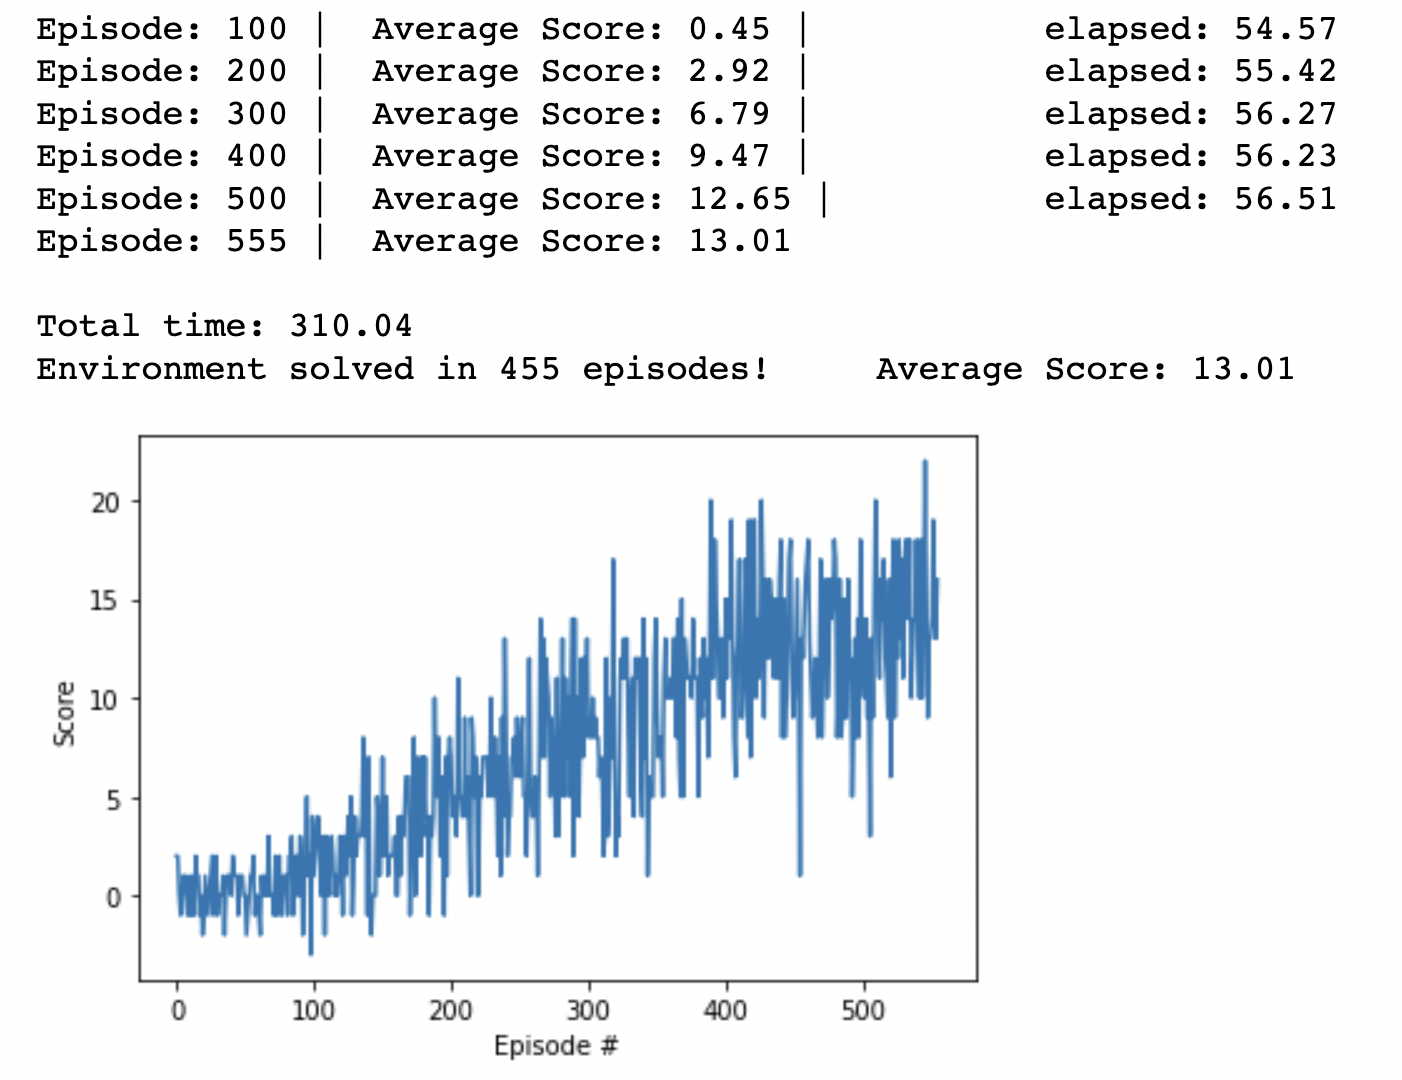

### Results, part 2: Training is faster on CPU than GPU??

I originally selected the **m6i.xlarge** AWS instance type to set up the Python packages on an inexpensive instance type, and then move the main training onto a AWS GPU-based instance for increased speed.

However, when I started moving some of the training over to AWS GPU instances, the total GPU training times were slower than the CPU training times. I did not record times for the smaller AWS GPU training sessions, but here's an example from my Macbook.

| Time | episodes |      structure     | batch size | update every | notes                        |
|:----:|:--------:|:------------------:|:----------:|:------------:|:------------------------------|
| 1220 |    480   |    64 / 64 / 64    |     128    |       6      | macbook m1 CPU               |
| 1262 |    417   |    64 / 64 / 64    |     128    |       6      | macbook m1 GPU (mps) enabled |
| 1358 |    440   | 2048 / 2048 / 2048 |     128    |       6      | macbook m1 GPU               |
| 5821 |    440   | 2048 / 2048 / 2048 |     128    |       6      | macbook m1 CPU (estimated)   |

Observations:

* the **64 / 64 / 64** training is faster on the CPU than the GPU on a Macbook Pro M1, even though the CPU and GPU share the same memory (the GPU M1 chip does not have its own dedicated RAM. This effect is even more pronounced on AWS instances, where the GPU has RAM separate from the CPU, and all the tensors have to be loaded into GPU memory before training can take place.
* On the M1 GPU going from 64 parameters per hidden layer to 2048 parameters per hidden layer, and increase of 3 order of magnitude, the running time only increased by 7.5%.
* On a CPU, increasing every hidden layerfrom 64 to 2048 parameters increased training time by 477%
* For small training runs where data is constantly being transferred between the CPU and GPU, running the training job on a CPU might be faster.
* m6i instance types feature Intel chips with some vector-acceleration operations built-in. In any case, the m6i CPU training times are almost 4x faster than the Macbook M1 CPU when training small models

### Results, part 3: Benchmark comparisons for 2048 x 2048 x 2048 hidden layers

Next, I wanted to run somewhat larger benchmarks on different AWS instance types.

The fastest (and most cost-effective) instance type for the Bananas project is **g5.xlarge** with a total training cost of **11.6 cents**.

If you can spare the time and you can find m6i spot instances at 8 cents an hour, the most cost-effective option is using the **m6i.xlarge** CPU. However, the regular price for this instance is 50-70% higher, which would make it more expensive than the **g5.xlarge**. The reason why I compare the **m6i** spot price to the regular GPU price is because spot instances are not available for GPUs -- they are too much in demand. In fact, for the us-east-1 region, GPUs are only available in the **us-east-1f** availability zone. No other zones have GPUs available, even at full price.

At $3/hour and going all the way up to a max configuration of 31/hr, the **p3** instance family features the most powerful GPU AWS offers. However, for a small training job like the Banana agent which isn't written in a way to take advantage of parallel processing, the **p3** benchmark performs far slower than the **g5**.

Another disappointment is the lackluster performance of the AWS Trainium chip, touted as a cost-effective alternative to existing GPUs. However, for $1.34/hr, you get 2 GPU cores (the only instance on this list with 2 GPUs) which this agent wasn't able to take advantage of. Still, it was the slowest GPU on this list.


| Time | Episodes | AWS cents/hr | total training cost | notes                               |
|:----:|:--------:|:----------:|:---------------:|:------------------------------------|
|      |          |            |                 |                                     |
| 5821 |    440   |            |                 | macbook m1 CPU (estimated)          |
| 3120 |    440   |      8     | **6.9**         | m6i CPU (estimated) (spot cost)     |
|      |          |            |                 |                                     |
| 1358 |    440   |            |                 | macbook m1 GPU                      |
|  848 |    351   |     75     | **17.7**        | g3s.xlarge (Tesla M60)              |
|  412 |    321   |     101    | **11.6**        | g5.xlarge (Nvidia A10G)             |
|  655 |    341   |     306    | **55.7**        | p3.2xlarge (Tesla V100)             |
|  870 |    388   |     134    | **32.4**        | trn1.2xlarge (Trainium1 custom AWS) |

How to read this table
* **Time**: total training time
* **Episodes**: how many episodes it took for the agent to "solve" the environment
* **cent/hr**: the cost to rent this instance type from AWS, on-demand rates
* **total training cost**: The total cost to train the agent with this instance type, in cents (lower is better)
* **notes**: the name of the AWS instance type, including the GPU model number used in that instance type. 

AWS Trainium chips are custom built for training ML models. Instance types also differ in disk space, RAM, and CPU cores, which account for the widely varying hourly cost. However, all the instance types used feature only 1 GPU, and they are all the least expensive options in their instance type group

### Results, part 4: Benchmarks for 4096 x 4096 x 4096

Another great performance for **g5**, another disppointing show for Trainium. Trainium was so slow that I shut it off before it completed. While the time gap between **g5** and **p3** has narrowed, the difference in cost still strongly favors **g5**. 

For medium-sized single-threaded GPU training, it looks like **g5** is our champion.

| Time | Episodes | AWS cents/hr | total training cost | Notes                               |
|:----:|:--------:|:----------:|:---------------:|:------------------------------------|
|      |          |            |                 |                                     |
|  821 |    479   |     101    |       23.0      | g5.xlarge (Nvidia A10G)             |
| 1042 |    503   |     306    |       88.6      | p3.2xlarge (Tesla V100)             |
| 2000 |    500   |     134    |       74.4      | trn1.2xlarge (Trainium1 custom AWS) |
|      |          |            |                 | (estimated, about 4 sec/episode)    |

# Failed Attempts

In this section, I describe experiments that failed.

### Single network DQN

I created a single-network DQN by commenting out all references to the **target** network. The memory buffer was also not needed. After 700 episodes, the agent was still moving randomly -- it had learned nothing.

Hyperparameters used:
* 3 hidden layers: 256 x 256 x 64
* batch size: 128
* update every: 6 episodes

### Reducing state

I had an idea that, if I reduced the size of the state, that the agent might be able to use a smaller network and solve the environment faster. The general idea was that, instead of one-hot encoding the yellow and blue banana states and then using a separate column for distance, why not use those values to denote the distance? 

Also, I removed the information for the presence of the wall and for agent, which was always of distance zero. Last, I removed the extreme angles of 20 degrees and 160 degrees.

This did not work. The agent made no progress at all, much less solve the environment.

Next, I restored all angles and velocities. So no progress.

I left the function in the file `dqn_agent.py`, but I inlcude it below for convenience:

```python
def convert_state_not_used(state):
    """Convert state from a 37-length vector to 11-length"""

    # state is a 37-length vector, consisting of 7 groups of 5 "rays" 
    #                          and 2 velocity floats
    # each ray group of 5 denotes a ray emanating outward from agent
    #       in degrees of [20, 90, 160, 45, 135, 70, 110]
    #    The 5 values are a one-hot encoding of 
    #                   [yellow banana, wall, blue banana, agent]
    #    The last value is a distance from agent to the object that's one-hot encoded
    # This function converts this set of 5 values into 2:
    #       [yellow banana, blue banana], and the values are the distances
    # Then, the 7 rays are reduced to 5: 
    #                   the 20 degree and 160 degree values are discarded
    # Lastly, only the forward velocity is saved, left/right velocity is discarded

    # indexes of the rays values to save
    # drop 20-degree and 160-degree indexes: 0 and 2 index
    take_indices = [1, 3, 4, 5, 6]

    # reshape rays into a 7x5 matrix
    rays = state.squeeze()[:-2].reshape(-1,5)

    # 16-length version, all velocities and angles
    return torch.Tensor(np.hstack((
        # yellow values are first column * distance
        rays[:,0] * rays[:,4],
        # blue values are first column * distance
        rays[:,2] * rays[:,4],
        # forward and sideways velocity
        state[-2:]
    )))

    # returned array (length=11):
    #       5x distance to yellow bananas in 5 directions
    #       5x distance to blue bananas in 5 directions
    #       forward velocity
    return torch.Tensor(np.hstack((
        # yellow values are first column * distance
        np.take(rays[:,0] * rays[:,4], take_indices),
        # blue values are first column * distance
        np.take(rays[:,2] * rays[:,4], take_indices),
        # forward velocity
        state[-1]
    )))
```

### Lower-dimension hidden layers

At around 32 x 32 x 32, the agent had problems remembering enough state to make progress in solving the environment.

### Visual learning using pixels

The files `model_pixel.py` and `Banana_pixel.ipynb` contain the implementation for my attempts to train the agent using only raw pixels. I was unable to get it working.

One problem was that the pixel training requires a MUCH higher parameter count, and I did not invest the time required to get the visual agent working on the AWS GPU instances. Even using the Macbook M1 GPU, the training was very slow, and often little better than random.

I tried 2 or 3 convolutional layers in the range of 64 x 128 x 256 filters with batch normalization and ReLU regularization for each CNN block, and a fully connected hidden layer of 1024 at the end.

# Next Steps

This section describes the next steps one might take with this project to make the agent stronger.

### Prioritized replay

The next step to reduce training time would be prioritized replay. This would consist of making sure that actions that resulting in a non-zero reward are always in the reply sample, instead of leaving it up to chance.

### Additional work on the pixel agent

Install a window manager within Ubuntu to get the visual agent working on an AWS GPU instance in order to run experiments faster and with deeper networks. As you can see above, the visual agent training code has already been written -- it just has to be run on a deeper network.